# Training and visualization

In this first tutorial we aim to show some basic functionality of our library. The main topics of this notebooks will be:
* visualization of a simple 2D dataset
* training of classifiers with SecML
* cross validation and parameter optimization
* visualization of the decision function of the trained classifiers

In [1]:
from collections import namedtuple
from math import ceil

from matplotlib.colors import ListedColormap

from secml.array import CArray
from secml.data.loader import CDLRandom
from secml.data.splitter import CDataSplitter
from secml.figure import CFigure
from secml.ml.classifiers import CClassifierSVM, CClassifierDecisionTree, CClassifierKNN, CClassifierSGD
from secml.ml.classifiers.loss import CLossHinge
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.classifiers.regularizer import CRegularizerL2
from secml.ml.features import CNormalizerMinMax
from secml.ml.peval import CPerfEvaluatorXVal
from secml.ml.peval.metrics import CMetric

## Visualization of a simple 2D dataset

The first step is to load the dataset. 
We will load a simple dataset composed by 3 clusters of points 
normally distributed. We will use a 2D dataset because it is 
easier to visualize. The dataset will be splitted in training
and testing set, and normalized into the interval [0, 1] 
with a normalizer.

In [2]:
random_state = 9999
n_classes = 3
n_features = 2
n_tr = 1000
n_ts = 200

dataset = CDLRandom(n_classes=n_classes, n_features=n_features, n_informative=n_features, n_redundant=0,
                    n_samples=n_tr + n_ts,
                    n_clusters_per_class=1, class_sep=2,
                    random_state=random_state).load()

idx = CArray.arange(0, dataset.num_samples)

idx.shuffle()
tr = dataset[n_tr:, :]
ts = dataset[:n_ts, :]

# Normalize the data
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X, tr.Y)
ts.X = nmz.transform(ts.X)

Now we can plot the samples in a 2D plane. 
The three clusters are clearly separable and normalized as we required.

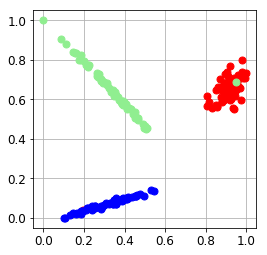

In [11]:
colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
cmap = ListedColormap(colors[:n_classes])

fig = CFigure(width=4, height=4)
fig.sp.plot_ds(tr, cmap=cmap)
fig.show()

In [4]:
multiclass = CClassifierMulticlassOVA(
    CClassifierSVM, C=1, kernel='rbf')

xval_params = {'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}

In [5]:
xval_splitter = CDataSplitter.create(
    'kfold', num_folds=3, random_state=50000)
best_params = multiclass.estimate_parameters(
    tr, xval_params, xval_splitter, 'accuracy',
    perf_evaluator='xval-multiclass', n_jobs=1)

print(best_params)

# set best parameters and fit
multiclass.set_params(best_params)
multiclass.fit(tr)

perf_eval = CPerfEvaluatorXVal(
    xval_splitter, CMetric.create('accuracy'))
print(perf_eval.compute_performance(multiclass, ts))

{'C': (1, 1, 1), 'kernel.gamma': (0.1, 0.1, 1)}
0.9798733604703754


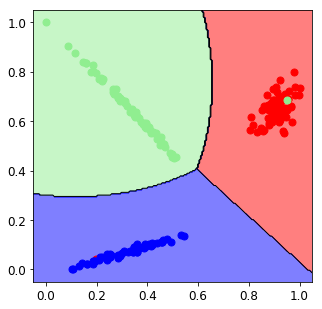

In [6]:
# plot decision function
colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
cmap = ListedColormap(colors[:n_classes])

fig = CFigure(width=5, height=5)

fig.sp.plot_decision_function(multiclass, n_grid_points=200, cmap=cmap)
fig.sp.plot_ds(tr, cmap=cmap)
fig.sp.grid(grid_on=False)
fig.show()

In [7]:
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')
clf_list = [
    CLF(
        clf_name='SVM Linear',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [1, 10, 100]}),
    CLF(clf_name='SVM Rbf',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}),
    CLF(clf_name='KNN',
        clf=CClassifierMulticlassOVA(CClassifierKNN),
        xval_parameters={'n_neighbors': [1, 3, 5]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierMulticlassOVA(CClassifierDecisionTree),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='SGD Linear',
        clf=CClassifierMulticlassOVA(CClassifierSGD, regularizer=CRegularizerL2(),
                                     loss=CLossHinge(), kernel='linear'),
        xval_parameters={'alpha': [0.01, 0.1, 1]}),
    CLF(clf_name='SGD RBF',
        clf=CClassifierMulticlassOVA(CClassifierSGD, regularizer=CRegularizerL2(),
                                     loss=CLossHinge(), kernel='rbf'),
        xval_parameters={'alpha': [0.01, 0.1, 1]}),
]

Classifier:           SVM Linear	Accuracy:0.97
Classifier:              SVM Rbf	Accuracy:0.98
Classifier:                  KNN	Accuracy:0.99
Classifier:        Decision Tree	Accuracy:0.97
Classifier:           SGD Linear	Accuracy:0.97
Classifier:              SGD RBF	Accuracy:0.99


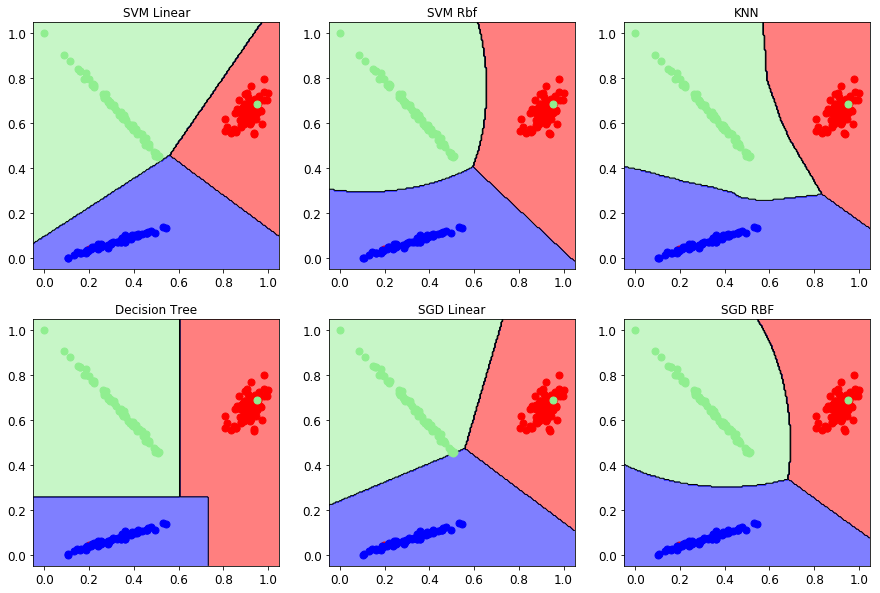

In [8]:
fig = CFigure(width=5 * len(clf_list)/2, height=5*2)

for clf_idx in range(len(clf_list)):
    clf = clf_list[clf_idx].clf
    xval_params = clf_list[clf_idx].xval_parameters
    xval_splitter = CDataSplitter.create(
        'kfold', num_folds=3, random_state=50000)

    best_params = clf.estimate_parameters(
        tr, xval_params, xval_splitter, 'accuracy',
        perf_evaluator='xval-multiclass', n_jobs=1)

    # set best parameters and fit
    clf.set_params(best_params)
    clf.fit(tr)

    perf_eval = CPerfEvaluatorXVal(
        xval_splitter, CMetric.create('accuracy'))
    print("Classifier: %20s\tAccuracy:%.2f" % 
          (clf_list[clf_idx].clf_name, 
           perf_eval.compute_performance(clf, ts)))

    # plot decision function
    fig.subplot(2, int(ceil(len(clf_list)/2)), clf_idx + 1)
    fig.sp.title(clf_list[clf_idx].clf_name)
    fig.sp.plot_decision_function(clf, n_grid_points=200, cmap=cmap)
    fig.sp.plot_ds(tr, cmap=cmap)
    fig.sp.grid(grid_on=False)

fig.show()